# Histopathological cancer detection using Convolutional Neural Net

The data has been taken from a Kaggle challenge: https://www.kaggle.com/c/histopathologic-cancer-detection/overview
The aim of the project is to identify metastatic cancer in small image patches taken from larger digital pathology scans.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/apple/miniconda3/envs/cta-dev/lib

In [2]:
# Example image
img = plt.imread('./train/f17f51f4df0f019d5caa5f587d9f3715890b8319.tif')
img.shape

(96, 96, 3)

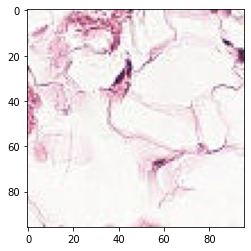

In [3]:
# Example image
plt.imshow(img)

# Load image data

In [4]:
# Read the train labels. Id = nomenclature of the image. label = whether the image contains a tumor
train_labels = pd.read_csv('./train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
#Due to memory allocation problem we will work with a subset of the data
# Load the train images and train labels
train_len = len(train_labels)
subset_size=1
subset_len = int(train_len*subset_size)

X = []
y = []

for i in tqdm(range(subset_len)):
    filename = train_labels.loc[i, 'id']
    img = plt.imread('./train/'+filename+'.tif')
    img_label = train_labels.loc[i, 'label']
    X.append(img)
    y.append(img_label)

100%|██████████| 220025/220025 [20:37<00:00, 177.82it/s]


In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
X.shape

(220025, 96, 96, 3)

In [8]:
y.shape

(220025,)

# Exploratory data analysis

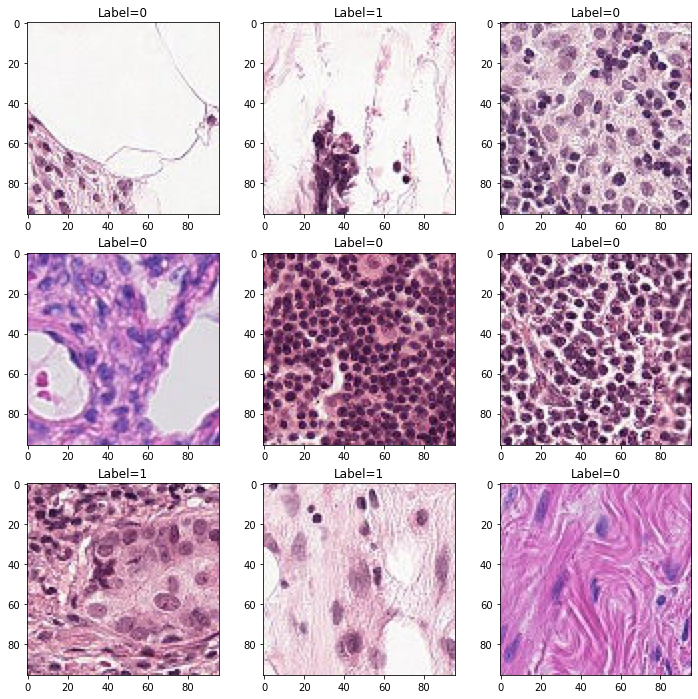

In [9]:
# Plot the first 9 images
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title('Label={}'.format(y[i]))
    plt.imshow(X[i])

([<matplotlib.axis.XTick at 0x12e59eb80>,
 [Text(0, 0, 'no tumor'), Text(0, 0, 'tumor')])

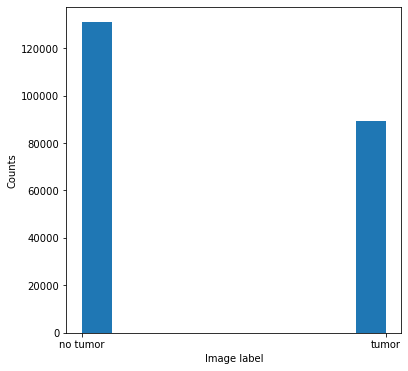

In [10]:
# Distribution of 0 and 1 in the labeled dataset
plt.figure(figsize=(6,6))
plt.hist(y)
plt.xlabel('Image label')
plt.ylabel('Counts')
plt.xticks([0,1], ['no tumor', 'tumor'])

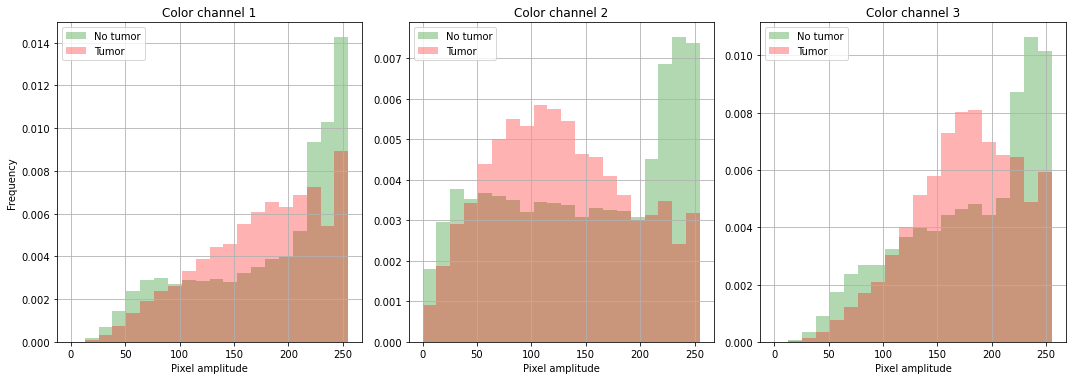

In [11]:
# Explore individual color channels in the image
def subsample(X, y, size=0.1):
    #This function chooses a subsample of images
    samplen = int(len(X)*size)
    Xnew = X[:samplen]
    ynew = y[:samplen]
    return Xnew, ynew

Xnew, ynew = subsample(X, y, size=0.01)

plt.figure(figsize=(15, 15))

plt.subplot(3,3,1)
plt.hist(np.ndarray.flatten(Xnew[ynew==0, :, :, 0]), bins=20, color='green', density=True, alpha=0.3, label='No tumor')
plt.hist(np.ndarray.flatten(Xnew[ynew==1, :, :, 0]), bins=20, color='red', density=True, alpha=0.3, label='Tumor')
plt.title('Color channel 1')
plt.xlabel('Pixel amplitude')
plt.ylabel('Frequency')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,3,2)
plt.hist(np.ndarray.flatten(Xnew[ynew==0, :, :, 1]), bins=20, color='green', density=True, alpha=0.3, label='No tumor')
plt.hist(np.ndarray.flatten(Xnew[ynew==1, :, :, 1]), bins=20, color='red', density=True, alpha=0.3, label='Tumor')
plt.title('Color channel 2')
plt.xlabel('Pixel amplitude')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,3,3)
plt.hist(np.ndarray.flatten(Xnew[ynew==0, :, :, 2]), bins=20, color='green', density=True, alpha=0.3, label='No tumor')
plt.hist(np.ndarray.flatten(Xnew[ynew==1, :, :, 2]), bins=20, color='red', density=True, alpha=0.3, label='Tumor')
plt.title('Color channel 3')
plt.xlabel('Pixel amplitude')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()

# Normalize the images
We wish to normalize each color channel so that they have a mean 0 and std. deviation 1. This is done because if a particular feature has a very large variance compared to others, the objective function is often dominated by this feature and hence it cannot learn effectively from the other features as expected.

In [12]:
norm_img = []

scaler = StandardScaler()

for i in tqdm(range(len(X))):
    raw = X[i]
    for chan in range(raw.shape[2]):
        raw[:, :, chan] = scaler.fit_transform(raw[:, :, chan])
    norm_img.append(raw)
    
X1 = np.array(norm_img)
print(X1.shape)

100%|██████████| 220025/220025 [12:42<00:00, 288.65it/s]


(220025, 96, 96, 3)


# Split the data into train, validation and test sets

In [14]:
X_interim, X_test, y_interim, y_test = train_test_split(X1, 
                                                        y, 
                                                        test_size=0.15, 
                                                        random_state=0)

#Further divide the interim dataset to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_interim, 
                                                  y_interim, 
                                                  test_size=0.15, 
                                                  random_state=0)

print(X_train.shape[0], ' train samples')
print(X_val.shape[0], ' validation samples')
print(X_test.shape[0], ' test samples')

158967  train samples
28054  validation samples
33004  test samples


# Convolutional Neural Network

In [15]:
num_class = len(np.unique(y_train)) - 1
# Since out classes are not balanced we will use class weights to weight them while model fitting
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(class_weights)

[0.83999303 1.2353092 ]


### The Convolutional Neural Network model

In [28]:
def CNN_model(Xt, yt, Xv, yv, epochs=50, batch=1000, patience=6, class_wgt=class_weights):
    #X = np.array(X)
    #y = np.array(y)
    input_dim = Xt[0].shape
    model = Sequential()
    model.add(Conv2D(24, kernel_size=5, strides=2, padding='valid', activation='relu', input_shape=input_dim))
    #model.add(MaxPooling2D(pool_size=3, strides=2, padding='valid'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='valid', activation='relu'))
    #model.add(MaxPooling2D(pool_size=3, strides=2, padding='valid'))
    model.add(MaxPooling2D())
    #model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=2, strides=1))
    model.add(Flatten())
    model.add(Dense(480, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(336, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_class, activation='sigmoid'))
    
    #Callbacks
    earlystop = EarlyStopping(monitor='val_acc', mode='max', patience=patience)
    checkpoint = ModelCheckpoint('./best_weights.hdf5', 
                                 monitor='val_acc', 
                                 mode='max', 
                                 save_weights_only=False, 
                                 save_best_only=True, 
                                 verbose=1)
    
    adam = keras.optimizers.Adam(lr=0.01)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    print(model.summary())
    
    
    history = model.fit(Xt, 
                        yt, 
                        batch_size=batch, 
                        epochs=epochs, 
                        callbacks=[earlystop, checkpoint], 
                        validation_data=(Xv, yv), 
                        class_weight=class_wgt, 
                        verbose=1)
    
    best_model = keras.models.load_model('./best_weights.hdf5') 
    return history,best_model

In [29]:
y_train.shape

(158967,)

In [ ]:
cnn_mod = CNN_model(X_train, y_train, X_val, y_val, epochs=100, batch=1600, patience=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 24)        1824      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 24)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 64)        24640     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 480)               768480    
_________________________________________________________________
dropout_7 (Dropout)          (None, 480)               0         
__________